### Using KDiffusion model, with t removed as baseline for future experiments

In [1]:
#!pip install -q diffusers datasets wandb lpips timm

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['OMP_NUM_THREADS']='1'

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: jantic. Use `wandb login --relogin` to force relogin


True

In [4]:
#@title imports
import wandb
import torch
import torchvision
from torch import nn
from torch import multiprocessing as mp
from torch.utils import data
from torchvision import datasets
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
from timm.optim.rmsprop_tf import RMSpropTF
from timm.optim.lookahead import Lookahead
import accelerate
from einops import rearrange
from functools import partial
import math
from copy import deepcopy
from pathlib import Path
from tqdm.auto import trange, tqdm
import k_diffusion as K
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

NOTE: Redirects are currently not supported in Windows or MacOs.


Using device: cuda


# Model and Training Setup

In [5]:
start_method = 'spawn' # the multiprocessing start method. Options: 'fork', 'forkserver', 'spawn'
skip_stages = 0
grad_accum_steps = 1
mp.set_start_method(start_method)
torch.backends.cuda.matmul.allow_tf32 = True

In [6]:
ddp_kwargs = accelerate.DistributedDataParallelKwargs(find_unused_parameters=skip_stages > 0)
accelerator = accelerate.Accelerator(kwargs_handlers=[ddp_kwargs], gradient_accumulation_steps=grad_accum_steps)
device = accelerator.device
print(f'Process {accelerator.process_index} using device: {device}', flush=True)

Process 0 using device: cuda


In [7]:
sz = 28
bs = 2048
lr = 1e-3
input_channels = 1
augment_prob = 0.12
sigma_data = 0.6162
mean = 0.2859
std = 0.353
sigma_min = 1e-2
sigma_max = 80
has_variance=True
sample_n = 64
num_workers = 8

In [8]:
def normalize_img(x):
    return (x-mean)/std

def denormalize_img(x):
    return (x*std)+mean

In [9]:
def RmsLookahead(params, alpha=0.5, k=6, *args, **kwargs):
    rmsprop = RMSpropTF(params, *args, **kwargs)
    return Lookahead(rmsprop, alpha, k)

In [10]:
def make_sample_density(mean=-1.2, std=1.2):
    #lognormal
    return partial(K.utils.rand_log_normal, loc=mean, scale=std)

In [11]:
def make_diffusion_model():
    #Model Config
    sz = 28
    size = [sz,sz]
    input_channels = 1
    patch_size= 1
    mapping_out= 256
    depths= [2, 4, 4]
    channels= [128, 128, 256]
    self_attn_depths = [False, False, True]
    cross_attn_depths = None
    has_variance = True
    dropout_rate = 0.05
    augment_wrapper = True
    skip_stages = 0

    model = K.models.ImageDenoiserModelV1(
        c_in=input_channels,
        feats_in=mapping_out,
        depths=depths,
        channels=channels,
        self_attn_depths=self_attn_depths,
        cross_attn_depths=cross_attn_depths,
        patch_size=patch_size,
        dropout_rate=dropout_rate,
        mapping_cond_dim= 9 if augment_wrapper else 0,
        unet_cond_dim = 0,
        cross_cond_dim = 0,
        skip_stages= skip_stages,
        has_variance=has_variance,
    )
    if augment_wrapper:
        model = K.augmentation.KarrasAugmentWrapper(model)
    return model

In [12]:
def make_denoiser_wrapper():
    if not has_variance:
        return partial(K.layers.Denoiser, sigma_data=sigma_data)
    return partial(K.layers.DenoiserWithVariance, sigma_data=sigma_data)

# Noise Classifier Training

In [13]:
class KarrasAugmentationPipelineCust(Transform):
    def __init__(self):
        self.pipeline = K.augmentation.KarrasAugmentationPipeline(augment_prob)
        
    def encodes(self, image):
        return self.pipeline(image)[0]

In [14]:
tfm = T.transforms.Compose([
    T.Resize(sz, interpolation=T.InterpolationMode.LANCZOS),
    T.CenterCrop(sz),
    #KarrasAugmentationPipelineCust()
])

In [15]:
dataset = datasets.FashionMNIST('data', train=True, download=True, transform=tfm)
print('Number of items in dataset:', len(dataset))

Number of items in dataset: 60000


In [16]:
def get_scalings(sigma):
    c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
    c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2) ** 0.5
    c_in = 1 / (sigma ** 2 + sigma_data ** 2) ** 0.5
    return c_skip, c_out, c_in

In [17]:
sample_density = make_sample_density()

In [18]:
def scale_model_input(input, sigma):
    _, _, c_in = [K.utils.append_dims(x, input.ndim) for x in get_scalings(sigma)]
    input = input * c_in 
    return input

In [19]:
sigmas_list = K.sampling.get_sigmas_karras(1000, sigma_min, sigma_max, rho=7., device=device)

In [20]:
def crappify(input:TensorImage):
    sigma_idx = torch.randint(low=0, high=len(sigmas_list)-1, size=(input.shape[0],))
    sigma = torch.ones([input.shape[0]], device=device)*(sigmas_list[sigma_idx] + torch.randn([input.shape[0]], device=device))
    
    #print(sigma.shape)
    #sigma = torch.rand([input.shape[0]], device=device) * (sigma_max - sigma_min) + sigma_min
    #sigma = sample_density([input.shape[0]], device=device)
    noise = torch.randn(input.shape).to(device) * K.utils.append_dims(sigma, input.ndim)
    noised_input = input + noise
    noised_input = noised_input
    #noised_input = scale_model_input(noised_input, sigma)
    return noised_input, sigma

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


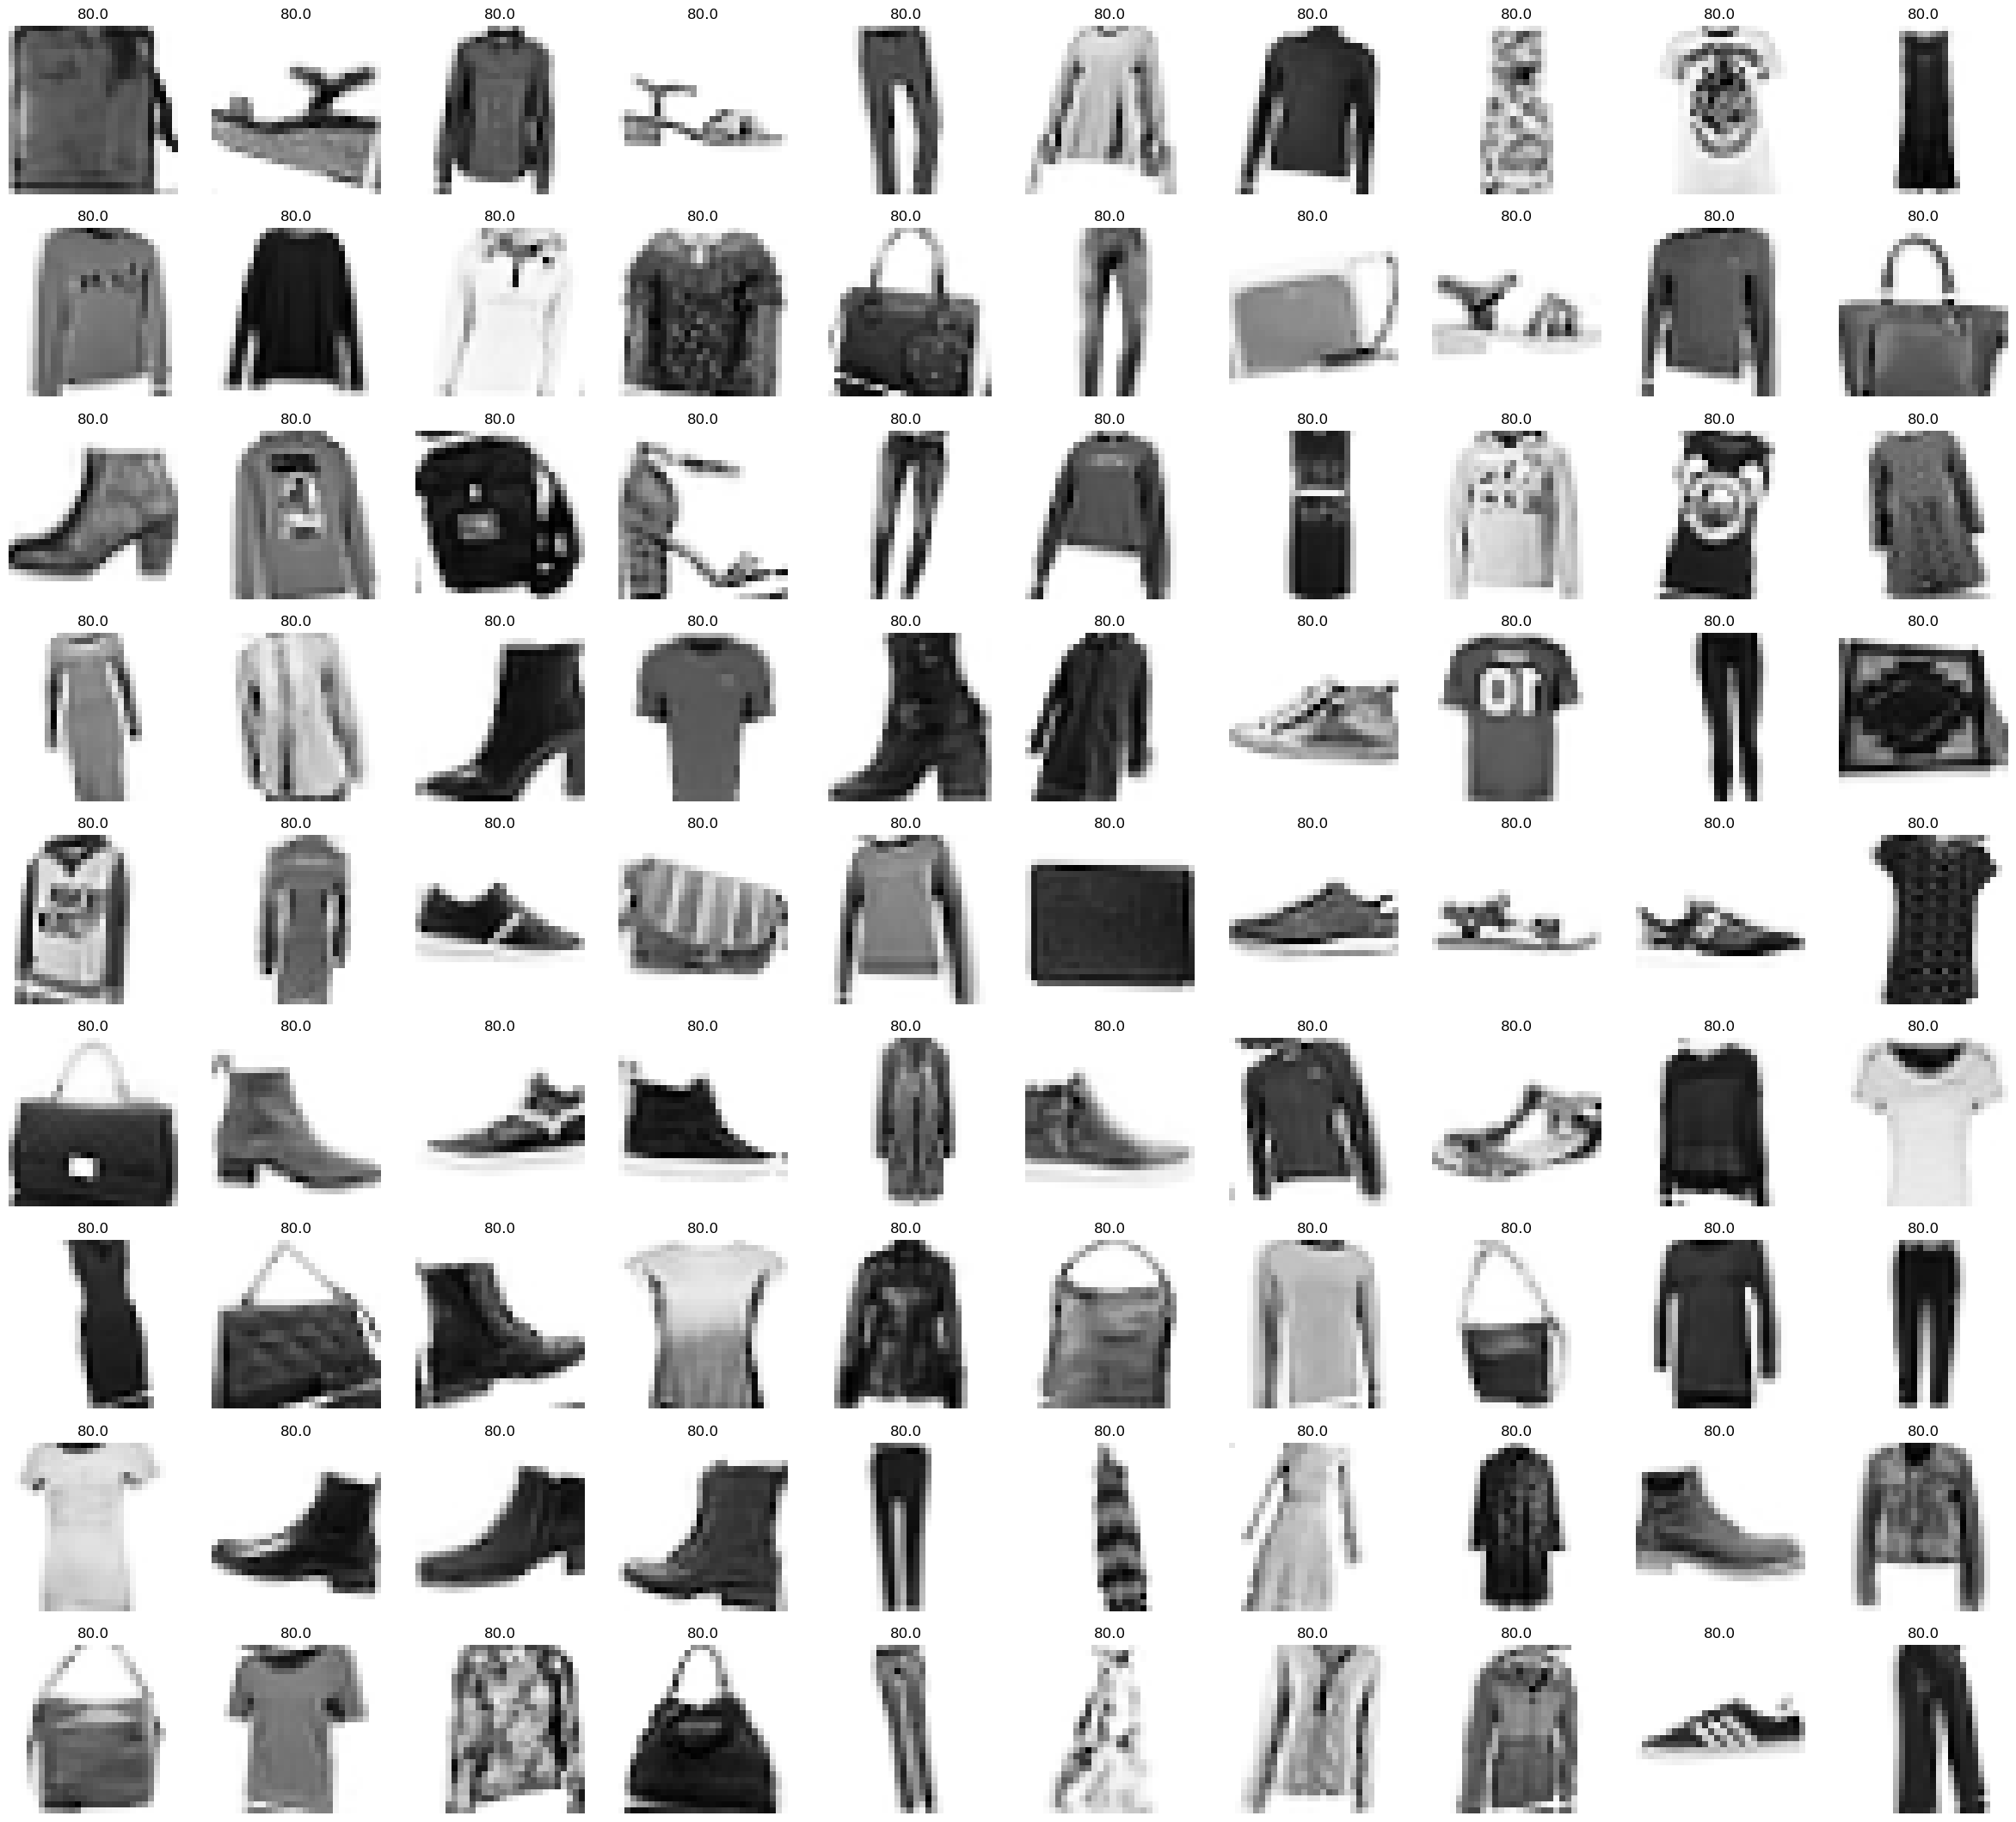

In [21]:
batch_tfms = aug_transforms()
batch_tfms.append(Normalize.from_stats(0.5, 0.5))

# Dataloader
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), RegressionBlock),
                   get_items=lambda pth: range(len(dataset)), # Gets the indexes
                   get_x=[lambda idx: np.array(dataset[idx][0])],
                   get_y=[lambda idx: sigma_max],
                   batch_tfms=batch_tfms)
dls = dblock.dataloaders('', bs=bs)
dls.show_batch(max_n=90)

In [22]:
class CrappificationCallback(Callback):
    def before_batch(self):
        x0 = self.learn.xb[0] # original images and labels
        #print(x0.max(), x0.min())
        xt, sigma = crappify(x0) # noise same shape as x0
        self.learn.xb = (xt,) # input to our model is noisy image, timestep and label
        self.learn.yb = (sigma,) # ground truth is the noise 

In [23]:
import timm

In [24]:
arch = partial(timm.create_model, 'resnetrs200', pretrained=True)

In [28]:
learn = vision_learner(dls, arch, loss_func=nn.L1Loss(), opt_func=partial(OptimWrapper, opt=RmsLookahead), n_in=1, n_out=1, y_range=(sigma_min, sigma_max), 
                       cbs=[CrappificationCallback()])       

C:\Users\jsa16\anaconda3\envs\course22p2\lib\site-packages\torch\_tensor.py:1121: UserWarning: Using a target size (torch.Size([2048])) that is different to the input size (torch.Size([2048, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.00363078061491251)

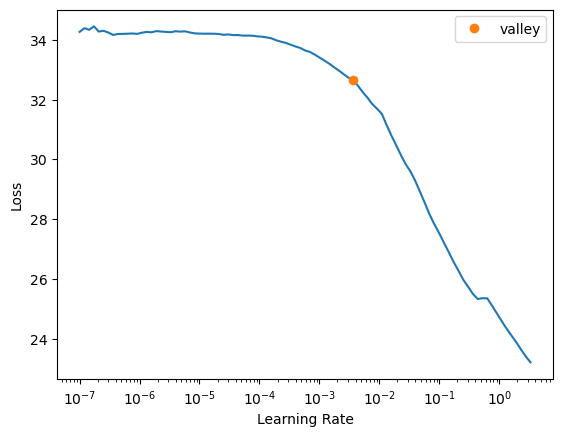

In [26]:
learn.lr_find()

In [29]:
learn.fine_tune(100, base_lr=1e-2)

epoch,train_loss,valid_loss,time
0,22.939627,13.512413,01:20


C:\Users\jsa16\anaconda3\envs\course22p2\lib\site-packages\torch\_tensor.py:1121: UserWarning: Using a target size (torch.Size([1760])) that is different to the input size (torch.Size([1760, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,time
0,13.864560,13.771007,01:29
1,13.918092,13.808266,01:29
2,13.997495,14.325958,01:30
3,13.894313,12.943288,01:29
4,13.617351,13.220692,01:29
5,13.371610,12.921383,01:29
6,13.291358,13.067586,01:30
7,13.252453,13.312786,01:29
8,13.259872,13.309431,01:29
9,13.155416,12.811332,01:29



KeyboardInterrupt

wandb: While tearing down the service manager. The following error has occured: [WinError 10054] An existing connection was forcibly closed by the remote host


In [ ]:
denoiser_name = 'denoiser_1'

In [ ]:
learn.save(denoiser_name)

# Optimizer Based Sampling

In [ ]:
def generate_random_noise(bs):
    return torch.randn(bs, 1, sz, sz, device=device) * sigma_max

def generate_random_noise_like(x):
    return torch.randn_like(x, device=device) * sigma_max

In [ ]:
learn.load(denoiser_name)

In [ ]:
sigma_model = learn.model.eval().to(device)

In [ ]:
checkpoints_dir = './checkpoints'
model_ema_path = Path(checkpoints_dir +'/kdiff_34_fmnist_ema.pt')

In [ ]:
model_ema = make_denoiser_wrapper()( make_diffusion_model().to(device)).eval()

In [ ]:
model_ema.load_state_dict(torch.load(str(model_ema_path)))

In [ ]:
def sample_based_on_optimizer(model_ema, sigma_model, xt, optim_fn, n_steps, lr_max, pct_start):
    with K.utils.eval_mode(model_ema):
        div=100000.
        div_final=1e5
        lr_sched_fn = combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final)
        optim = OptimWrapper(opt=optim_fn([xt], lr=lr_max))
        prev_noise_var = 1e6
        eps = None
        xt.requires_grad = True
        sigma = torch.ones([num_examples, 1], device=device) * sigma_max

        for i in range(n_steps):
            pos = i/(n_steps)
            lr = lr_sched_fn(pos)
            optim.set_hyper('lr', lr)
            in_xt = xt

            with torch.no_grad():
                #print(sigma_model(in_xt)[0])
                pred = model_ema(in_xt, sigma)
                eps = in_xt-pred
                sigma = sigma_model(pred)

            # # Early stopping
            #if (eps.float()).var() < 0.01 or i == n_steps-1:
            #    print('Stopping at:', i)
            #    return pred, eps

            xt.grad = eps.float()
            grad_mean = eps.mean()
            prev_noise_var = eps.float().var()

            #if i%10==0:
            #    print(i, xt.grad.mean(), xt.grad.var(), xt.float().var(), lr) # Useful to watch the noise variance


            optim.step()
            optim.zero_grad() 


            #if i%10==0:
            #    print('xt:', i, xt.mean(), xt.max(), xt.min())

            #if grad_mean < 0.0:
            #    return xt, eps

        return xt, eps

def generate_opt_based_samples(model_ema, sigma_model, xt):
    sgd_optim_fn = partial(torch.optim.SGD, momentum=0.01)
    xt = xt.clone()
    xt, eps = sample_based_on_optimizer(model_ema, sigma_model, xt=xt, optim_fn=sgd_optim_fn, n_steps=40, lr_max=2e-2, pct_start=0.25)
    #xt, eps = sample_based_on_optimizer(model_ema, sigma_model, xt=xt, optim_fn=sgd_optim_fn, n_steps=10, lr_max=3e-2, pct_start=0.5)
    #xt, eps = sample_based_on_optimizer(model_ema, sigma_model, xt=xt,  optim_fn=RmsLookahead, n_steps=20, lr_max=5e-2, pct_start=0.25)
    pred_image = xt
    return pred_image, eps

In [ ]:
torch.random.manual_seed(1000)
num_examples = 80
#xt = generate_random_noise(num_examples).to(device)
xt = torch.randn([num_examples, input_channels, sz, sz], device=device) * sigma_max
## Seem to get better results with 0.95 noise_amount rather than 1.0
pred_image, eps = generate_opt_based_samples(model_ema, sigma_model, xt=xt)
#pred_image = denormalize_img(pred_image).detach().cpu()
pred_image = pred_image.detach().cpu()
xt = xt.detach().cpu()
eps = eps.detach().cpu()
#pred_img = (pred_image).clip(0, 1)
grid = torchvision.utils.make_grid(pred_image, nrow=8, padding=0)
grid = K.utils.to_pil_image(grid)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(grid)

In [ ]:
for i in range(100):
    input = K.utils.from_pil_image(dataset[0][0]).unsqueeze(0).to(device)
    sigma = sample_density([input.shape[0]], device=device)
    noise = torch.randn(input.shape).to(device) * K.utils.append_dims(sigma, input.ndim)
    noised_input = input + noise
    pred = sigma_model(noised_input)
    print(sigma[0], pred[0])

In [ ]:
@torch.no_grad()
def sample_lms(model_ema, size):
    with K.utils.eval_mode(model_ema):
        n_per_proc = math.ceil(sample_n / accelerator.num_processes)
        x = torch.randn([n_per_proc, input_channels, size[0], size[1]], device=device) * sigma_max
        sigmas = K.sampling.get_sigmas_karras(50, sigma_min, sigma_max, rho=7., device=device)
        print(x.max(), x.min())
        pred_sigmas = sigma_model(x)
        print(sigmas[0], pred_sigmas[0])
        x_0 = K.sampling.sample_lms(model_ema, x, sigmas, disable=not accelerator.is_main_process)
        x_0 = accelerator.gather(x_0)[:sample_n]
        # For some reason the images are inverting...
        x_0 = -x_0

        grid = torchvision.utils.make_grid(x_0, nrow=math.ceil(sample_n ** 0.5), padding=0)
        return K.utils.to_pil_image(grid)

In [ ]:
grid = sample_lms(model_ema, [sz,sz])
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(grid)